In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import json

In [7]:
# ... existing code ...

# Load and process the data
print("Loading data...")

# Load market data
market_data = pd.read_csv('market_data.csv')
market_data['Date'] = pd.to_datetime(market_data['Date'])
market_data = market_data.pivot(index='Date', columns='symbol', values='price')

# Load positions data
with open('logs/strategy_data/positions.json', 'r') as f:
    positions_data = json.load(f)

# Get available strategies
strategies = list(positions_data.keys())
print(f"Available strategies: {strategies}")

# Get available symbols from positions data
all_symbols = set()
for strategy in strategies:
    all_symbols.update(positions_data[strategy].keys())

print(f"Available symbols: {sorted(list(all_symbols))[:10]}...")  # Show first 10

# Select a representative symbol for detailed analysis (e.g., AAPL)
analysis_symbol = 'AAPL'
print(f"\nAnalyzing symbol: {analysis_symbol}")

# ... existing code ...

Loading data...
Available strategies: ['VolatilityBreakoutStrategy', 'MACDStrategy', 'RSIStrategy', 'MovingAverageStrategy', 'BenchmarkStrategy']
Available symbols: ['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM']...

Analyzing symbol: AAPL


In [8]:
# ... existing code ...

# Process positions data for each strategy
def process_strategy_positions(strategy_name, symbol):
    """Process positions data for a specific strategy and symbol"""
    if symbol not in positions_data[strategy_name]:
        return None
    
    symbol_data = positions_data[strategy_name][symbol]
    
    # Convert to DataFrame
    dates = []
    quantities = []
    avg_prices = []
    cash_balances = []
    
    for date_str, position in symbol_data.items():
        dates.append(pd.to_datetime(date_str))
        quantities.append(position['qty'])
        avg_prices.append(position['avg_price'])
        cash_balances.append(position['remaining_cash'])
    
    df = pd.DataFrame({
        'Date': dates,
        'Quantity': quantities,
        'AvgPrice': avg_prices,
        'Cash': cash_balances
    }).sort_values('Date')
    
    return df

# Process all strategies for the analysis symbol
strategy_data = {}
for strategy in strategies:
    data = process_strategy_positions(strategy, analysis_symbol)
    if data is not None:
        strategy_data[strategy] = data
        print(f"{strategy}: {len(data)} position records")

# ... existing code ...

VolatilityBreakoutStrategy: 39 position records
MACDStrategy: 21 position records
RSIStrategy: 41 position records
MovingAverageStrategy: 6 position records
BenchmarkStrategy: 1 position records


/var/folders/f0/gc3h36y11691l12q208g38l80000gn/T/ipykernel_52017/2112051018.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = merged.fillna(method='ffill')  # Forward fill missing prices
/var/folders/f0/gc3h36y11691l12q208g38l80000gn/T/ipykernel_52017/2112051018.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = merged.fillna(method='ffill')  # Forward fill missing prices
/var/folders/f0/gc3h36y11691l12q208g38l80000gn/T/ipykernel_52017/2112051018.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = merged.fillna(method='ffill')  # Forward fill missing prices
/var/folders/f0/gc3h36y11691l12q208g38l80000gn/T/ipykernel_52017/2112051018.py:52: FutureWarning: DataFrame.fillna with 'method

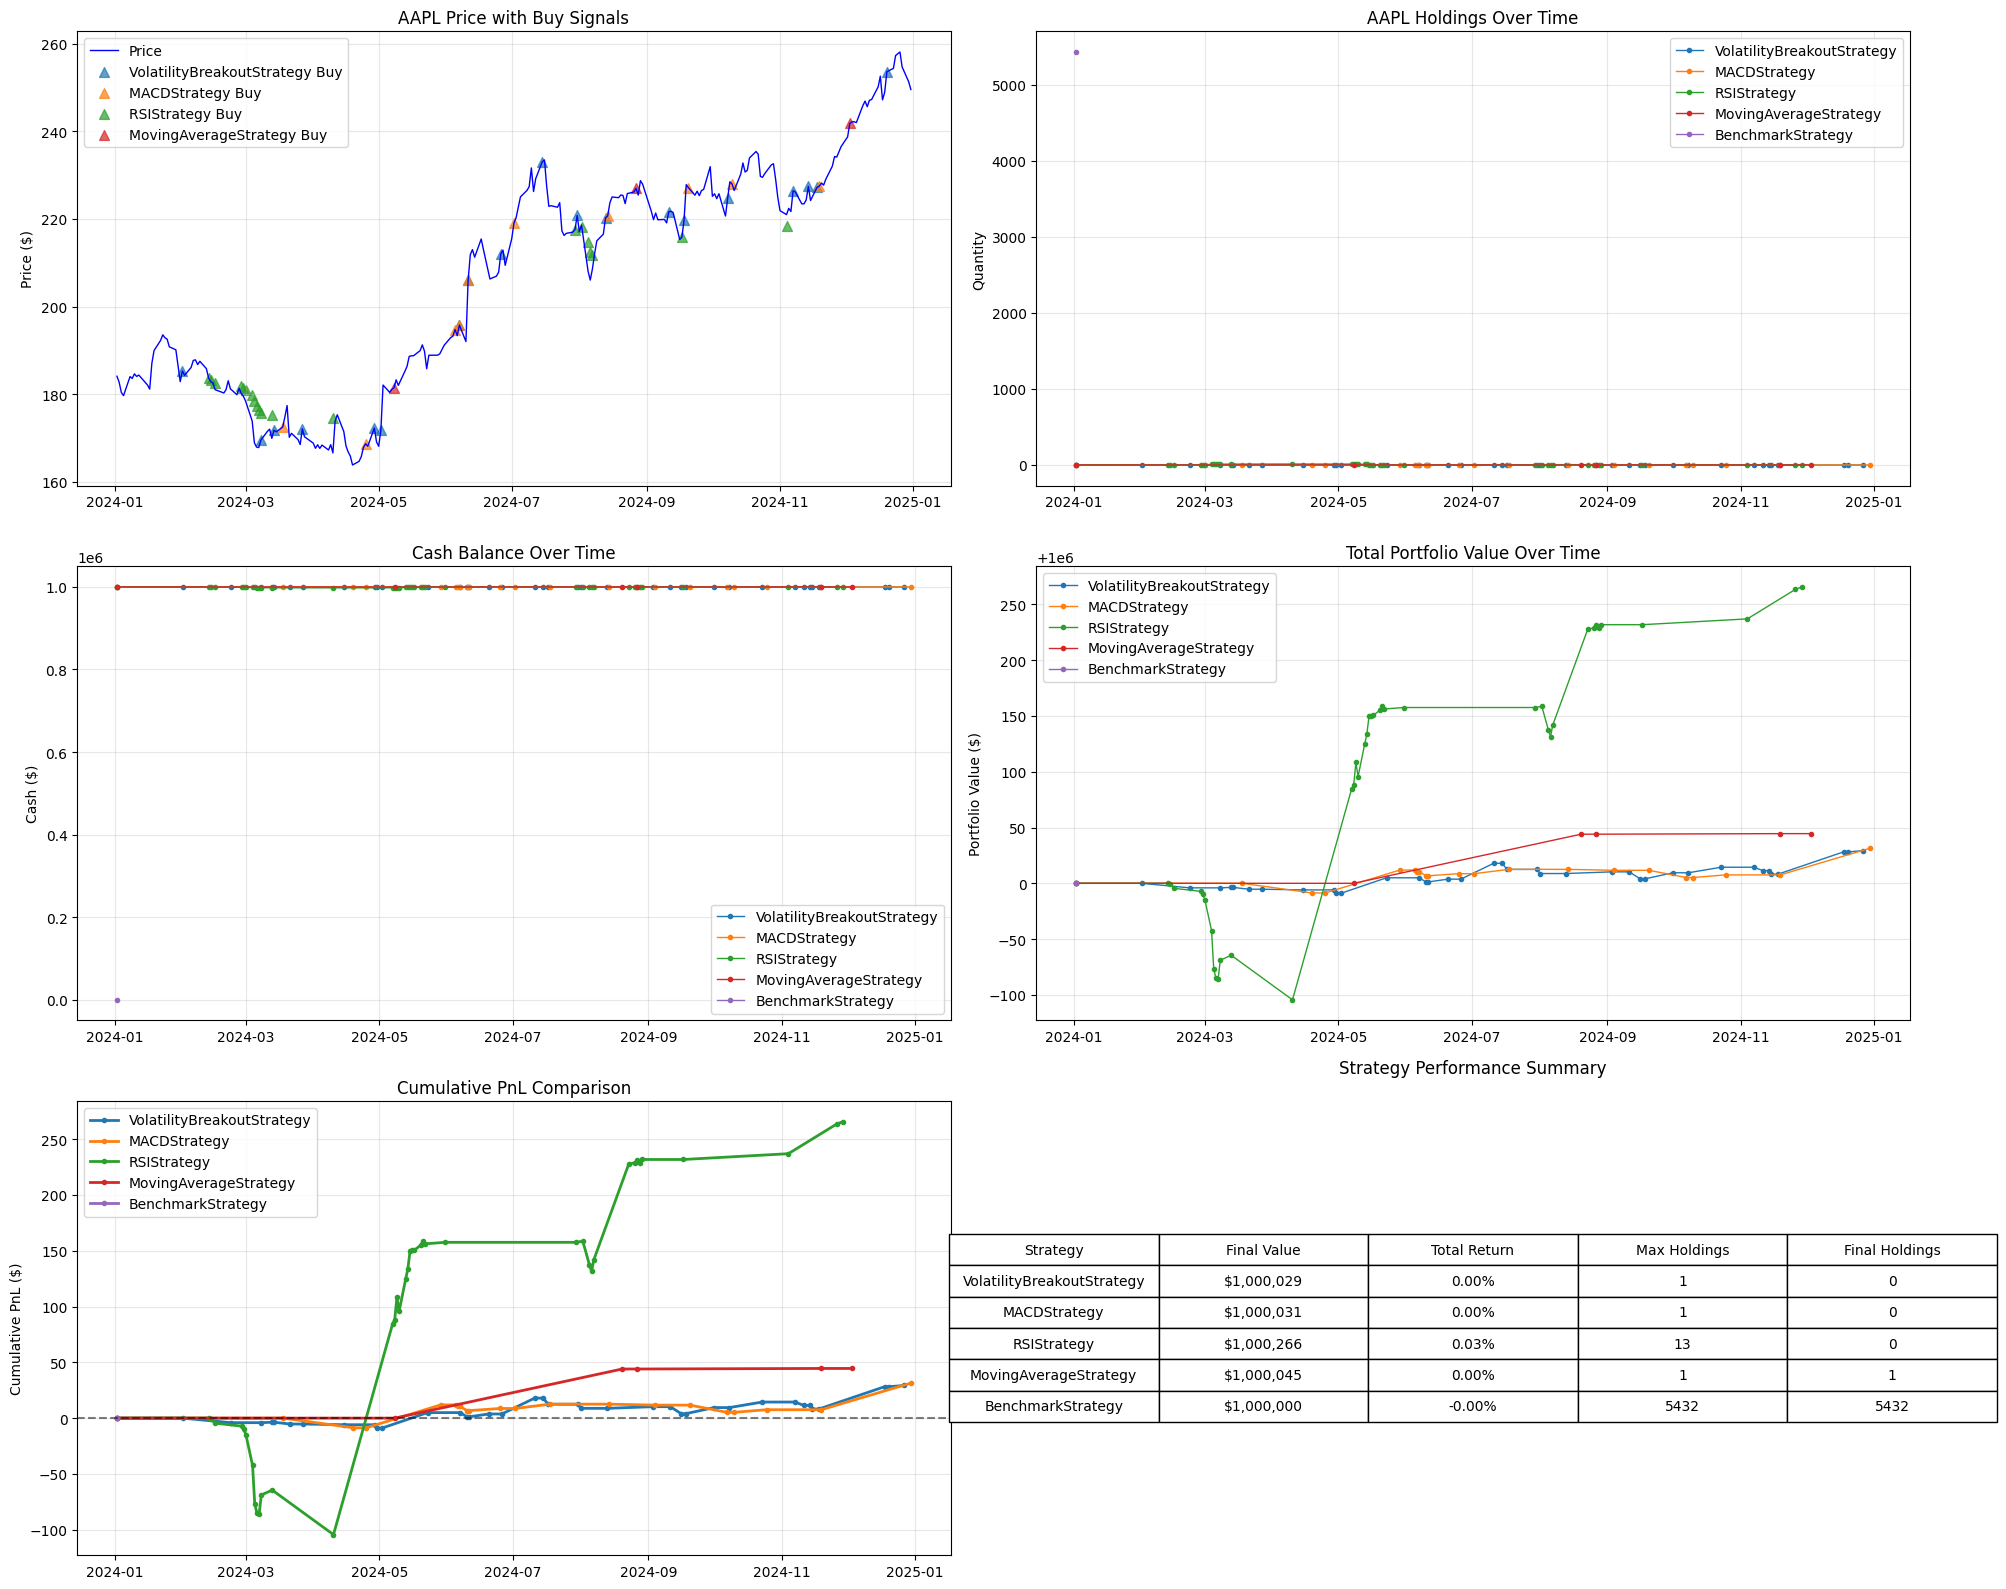

In [9]:
# ... existing code ...

# Create comprehensive analysis plots
fig = plt.figure(figsize=(20, 16))

# 1. Signal overlay on price chart
ax1 = plt.subplot(3, 2, 1)
if analysis_symbol in market_data.columns:
    price_data = market_data[analysis_symbol].dropna()
    ax1.plot(price_data.index, price_data.values, 'b-', linewidth=1, label='Price')
    
    # Add buy signals (when quantity increases)
    for strategy_name, data in strategy_data.items():
        buy_signals = data[data['Quantity'] > data['Quantity'].shift(1)]
        if len(buy_signals) > 0:
            ax1.scatter(buy_signals['Date'], buy_signals['AvgPrice'], 
                       marker='^', s=50, alpha=0.7, label=f'{strategy_name} Buy')

ax1.set_title(f'{analysis_symbol} Price with Buy Signals')
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Holdings over time
ax2 = plt.subplot(3, 2, 2)
for strategy_name, data in strategy_data.items():
    ax2.plot(data['Date'], data['Quantity'], marker='o', markersize=3, 
             linewidth=1, label=strategy_name)

ax2.set_title(f'{analysis_symbol} Holdings Over Time')
ax2.set_ylabel('Quantity')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Cash balance over time
ax3 = plt.subplot(3, 2, 3)
for strategy_name, data in strategy_data.items():
    ax3.plot(data['Date'], data['Cash'], marker='o', markersize=3, 
             linewidth=1, label=strategy_name)

ax3.set_title('Cash Balance Over Time')
ax3.set_ylabel('Cash ($)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Total portfolio value over time
ax4 = plt.subplot(3, 2, 4)
for strategy_name, data in strategy_data.items():
    if analysis_symbol in market_data.columns:
        # Merge with price data to calculate portfolio value
        merged = data.set_index('Date').join(market_data[analysis_symbol], how='left')
        merged = merged.fillna(method='ffill')  # Forward fill missing prices
        portfolio_value = merged['Quantity'] * merged[analysis_symbol] + merged['Cash']
        ax4.plot(merged.index, portfolio_value, marker='o', markersize=3, 
                 linewidth=1, label=strategy_name)

ax4.set_title('Total Portfolio Value Over Time')
ax4.set_ylabel('Portfolio Value ($)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Cumulative PnL comparison
ax5 = plt.subplot(3, 2, 5)
initial_capital = 1000000  # From the data

for strategy_name, data in strategy_data.items():
    if analysis_symbol in market_data.columns:
        merged = data.set_index('Date').join(market_data[analysis_symbol], how='left')
        merged = merged.fillna(method='ffill')
        portfolio_value = merged['Quantity'] * merged[analysis_symbol] + merged['Cash']
        cumulative_pnl = portfolio_value - initial_capital
        ax5.plot(merged.index, cumulative_pnl, marker='o', markersize=3, 
                 linewidth=2, label=strategy_name)

ax5.set_title('Cumulative PnL Comparison')
ax5.set_ylabel('Cumulative PnL ($)')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 6. Strategy performance summary
ax6 = plt.subplot(3, 2, 6)
ax6.axis('off')

# Calculate final performance metrics
performance_summary = []
for strategy_name, data in strategy_data.items():
    if analysis_symbol in market_data.columns:
        merged = data.set_index('Date').join(market_data[analysis_symbol], how='left')
        merged = merged.fillna(method='ffill')
        final_portfolio_value = (merged['Quantity'].iloc[-1] * merged[analysis_symbol].iloc[-1] + 
                                merged['Cash'].iloc[-1])
        total_return = (final_portfolio_value - initial_capital) / initial_capital * 100
        max_quantity = merged['Quantity'].max()
        final_quantity = merged['Quantity'].iloc[-1]
        
        performance_summary.append([
            strategy_name,
            f"${final_portfolio_value:,.0f}",
            f"{total_return:.2f}%",
            f"{max_quantity}",
            f"{final_quantity}"
        ])

# Create table
table_data = [['Strategy', 'Final Value', 'Total Return', 'Max Holdings', 'Final Holdings']] + performance_summary
table = ax6.table(cellText=table_data, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
ax6.set_title('Strategy Performance Summary', pad=20)

plt.tight_layout()
plt.show()

# ... existing code ...

In [10]:
# ... existing code ...

# Additional analysis: Signal behavior and execution constraints
print("\n" + "="*60)
print("SIGNAL BEHAVIOR AND EXECUTION ANALYSIS")
print("="*60)

for strategy_name, data in strategy_data.items():
    print(f"\n{strategy_name}:")
    print(f"  Total trades: {len(data[data['Quantity'] != data['Quantity'].shift(1)])}")
    print(f"  Max position size: {data['Quantity'].max()}")
    print(f"  Final position size: {data['Quantity'].iloc[-1]}")
    print(f"  Days with positions: {len(data[data['Quantity'] > 0])}")
    print(f"  Final cash: ${data['Cash'].iloc[-1]:,.0f}")
    
    # Calculate trade frequency
    trade_dates = data[data['Quantity'] != data['Quantity'].shift(1)]['Date']
    if len(trade_dates) > 1:
        avg_days_between_trades = (trade_dates.iloc[-1] - trade_dates.iloc[0]).days / (len(trade_dates) - 1)
        print(f"  Avg days between trades: {avg_days_between_trades:.1f}")

# Performance comparison
print(f"\nPERFORMANCE COMPARISON:")
print("-" * 40)
for strategy_name, data in strategy_data.items():
    if analysis_symbol in market_data.columns:
        merged = data.set_index('Date').join(market_data[analysis_symbol], how='left')
        merged = merged.fillna(method='ffill')
        final_value = merged['Quantity'].iloc[-1] * merged[analysis_symbol].iloc[-1] + merged['Cash'].iloc[-1]
        total_return = (final_value - initial_capital) / initial_capital * 100
        print(f"{strategy_name:20}: {total_return:8.2f}% return")

# ... existing code ...


SIGNAL BEHAVIOR AND EXECUTION ANALYSIS

VolatilityBreakoutStrategy:
  Total trades: 39
  Max position size: 1
  Final position size: 0
  Days with positions: 19
  Final cash: $1,000,029
  Avg days between trades: 9.5

MACDStrategy:
  Total trades: 21
  Max position size: 1
  Final position size: 0
  Days with positions: 10
  Final cash: $1,000,031
  Avg days between trades: 18.1

RSIStrategy:
  Total trades: 41
  Max position size: 13
  Final position size: 0
  Days with positions: 37
  Final cash: $1,000,266
  Avg days between trades: 8.3

MovingAverageStrategy:
  Total trades: 6
  Max position size: 1
  Final position size: 1
  Days with positions: 3
  Final cash: $999,803
  Avg days between trades: 67.2

BenchmarkStrategy:
  Total trades: 1
  Max position size: 5432
  Final position size: 5432
  Days with positions: 1
  Final cash: $69

PERFORMANCE COMPARISON:
----------------------------------------
VolatilityBreakoutStrategy:     0.00% return
MACDStrategy        :     0.00% retur

/var/folders/f0/gc3h36y11691l12q208g38l80000gn/T/ipykernel_52017/1384802267.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = merged.fillna(method='ffill')
/var/folders/f0/gc3h36y11691l12q208g38l80000gn/T/ipykernel_52017/1384802267.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = merged.fillna(method='ffill')
/var/folders/f0/gc3h36y11691l12q208g38l80000gn/T/ipykernel_52017/1384802267.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = merged.fillna(method='ffill')
/var/folders/f0/gc3h36y11691l12q208g38l80000gn/T/ipykernel_52017/1384802267.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
 

/var/folders/f0/gc3h36y11691l12q208g38l80000gn/T/ipykernel_52017/3406443558.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = merged.fillna(method='ffill')
/var/folders/f0/gc3h36y11691l12q208g38l80000gn/T/ipykernel_52017/3406443558.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = merged.fillna(method='ffill')
/var/folders/f0/gc3h36y11691l12q208g38l80000gn/T/ipykernel_52017/3406443558.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = merged.fillna(method='ffill')
/var/folders/f0/gc3h36y11691l12q208g38l80000gn/T/ipykernel_52017/3406443558.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
 

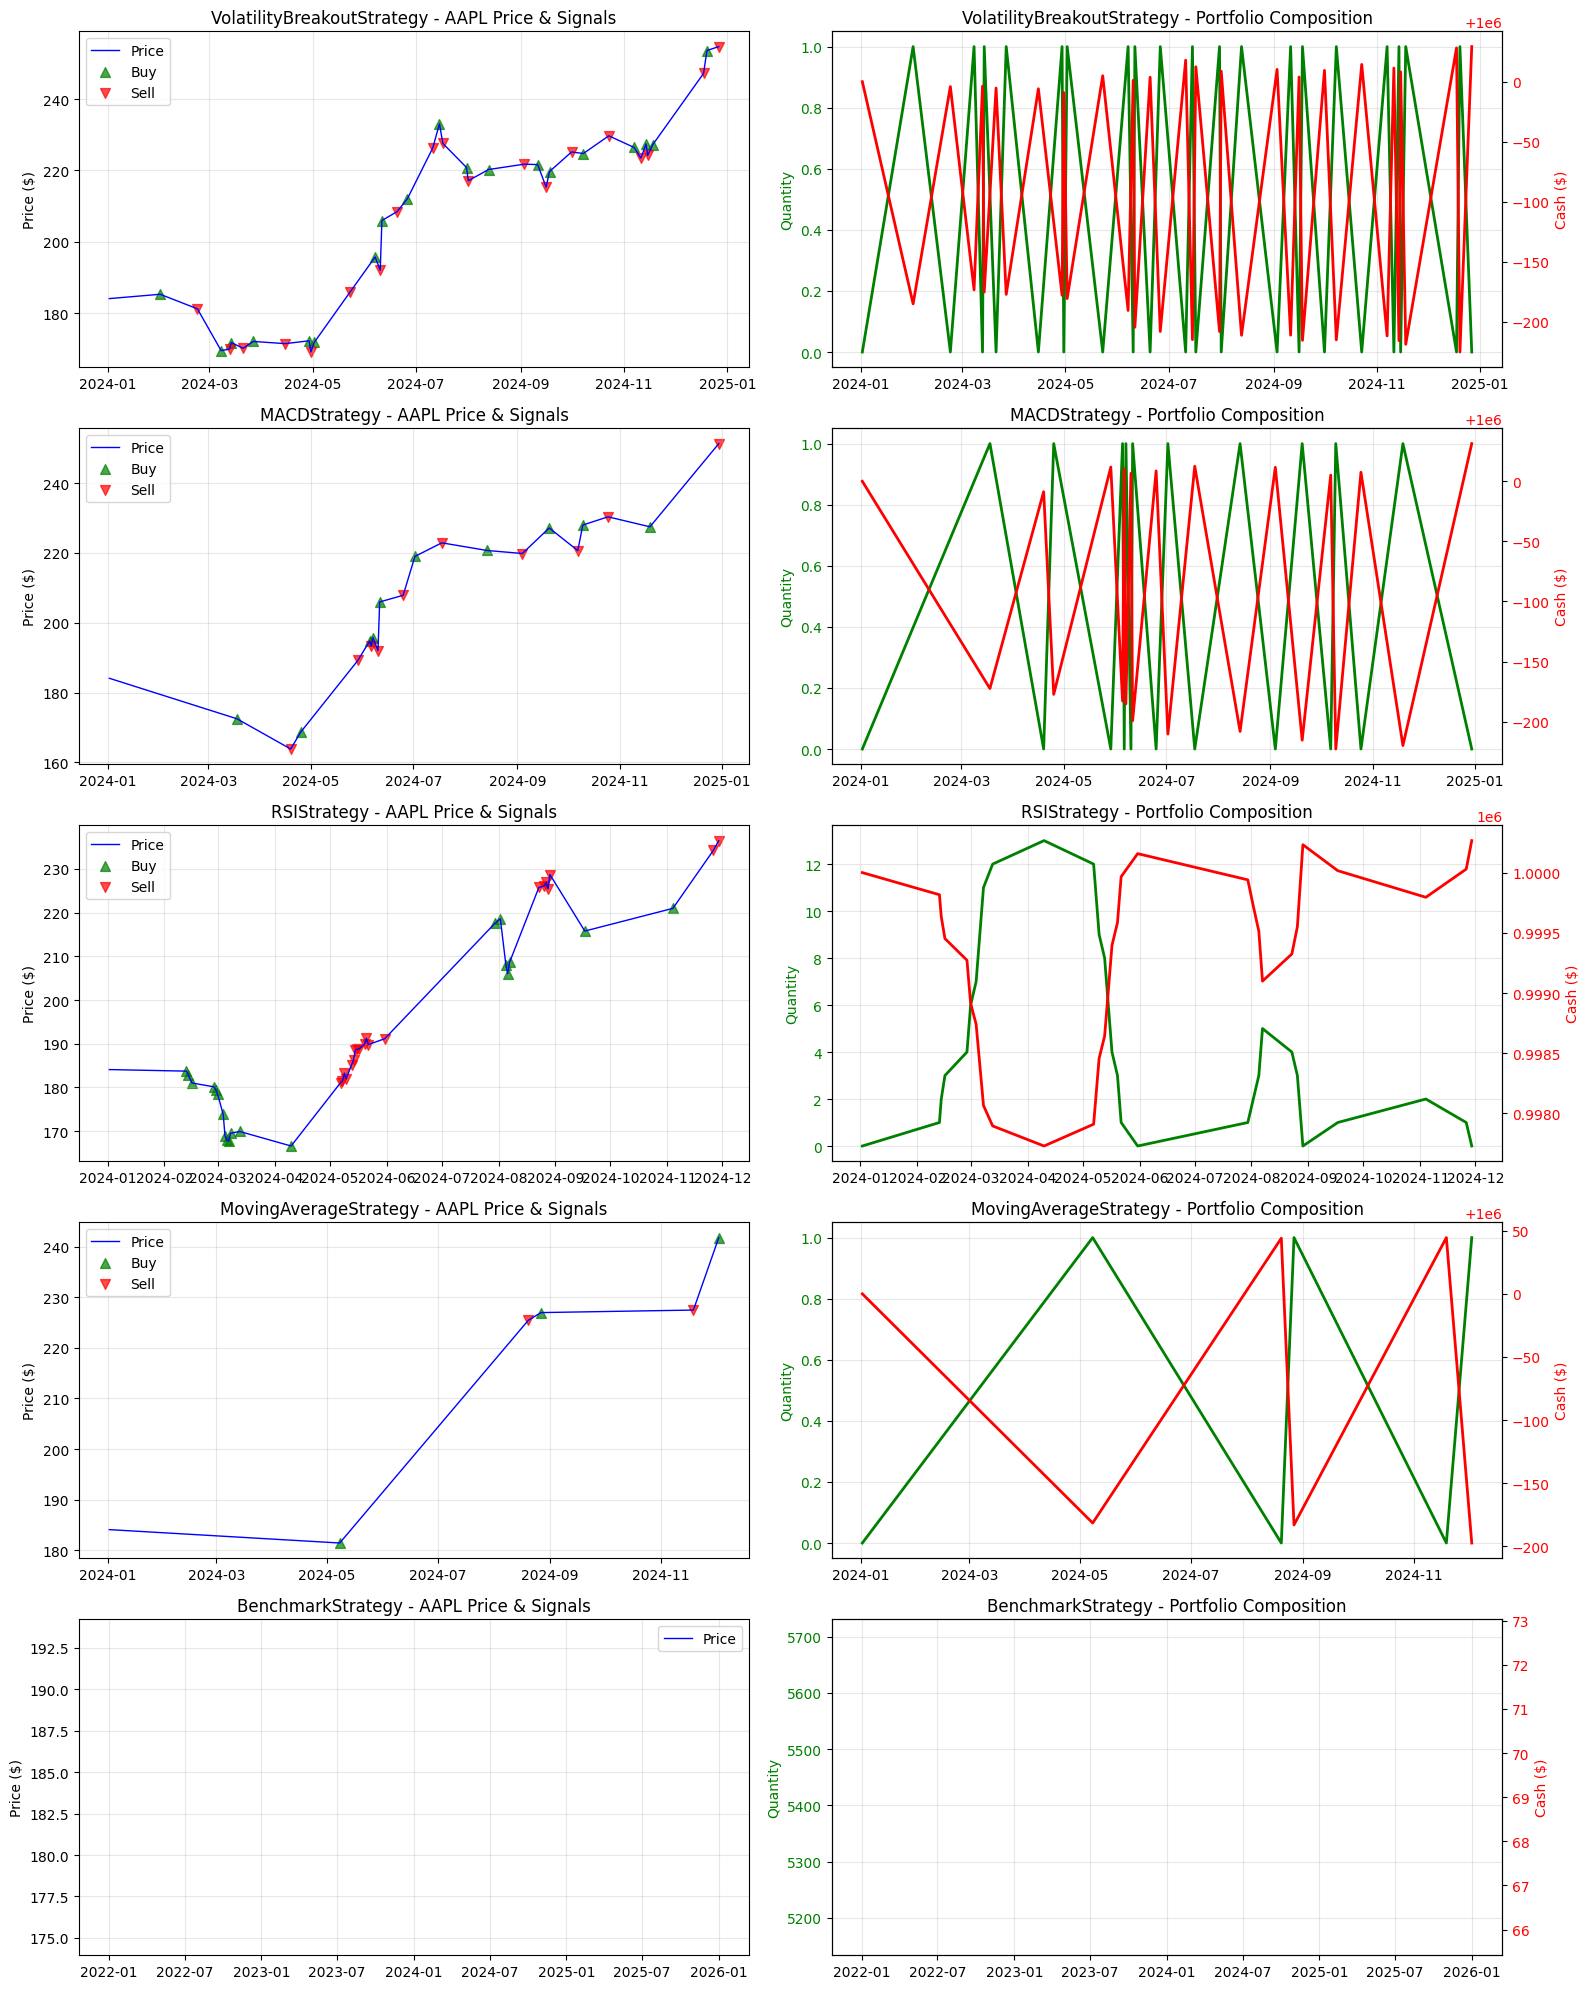

In [11]:
# ... existing code ...

# Create individual detailed charts for each strategy
fig, axes = plt.subplots(len(strategy_data), 2, figsize=(16, 4*len(strategy_data)))
if len(strategy_data) == 1:
    axes = axes.reshape(1, -1)

for i, (strategy_name, data) in enumerate(strategy_data.items()):
    if analysis_symbol in market_data.columns:
        merged = data.set_index('Date').join(market_data[analysis_symbol], how='left')
        merged = merged.fillna(method='ffill')
        
        # Price and signals
        ax1 = axes[i, 0]
        ax1.plot(merged.index, merged[analysis_symbol], 'b-', linewidth=1, label='Price')
        
        # Mark buy/sell points
        buy_points = merged[merged['Quantity'] > merged['Quantity'].shift(1)]
        sell_points = merged[merged['Quantity'] < merged['Quantity'].shift(1)]
        
        if len(buy_points) > 0:
            ax1.scatter(buy_points.index, buy_points[analysis_symbol], 
                       marker='^', color='green', s=50, alpha=0.7, label='Buy')
        if len(sell_points) > 0:
            ax1.scatter(sell_points.index, sell_points[analysis_symbol], 
                       marker='v', color='red', s=50, alpha=0.7, label='Sell')
        
        ax1.set_title(f'{strategy_name} - {analysis_symbol} Price & Signals')
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Portfolio composition
        ax2 = axes[i, 1]
        ax2_twin = ax2.twinx()
        
        # Holdings
        ax2.plot(merged.index, merged['Quantity'], 'g-', linewidth=2, label='Holdings')
        ax2.set_ylabel('Quantity', color='g')
        ax2.tick_params(axis='y', labelcolor='g')
        
        # Cash
        ax2_twin.plot(merged.index, merged['Cash'], 'r-', linewidth=2, label='Cash')
        ax2_twin.set_ylabel('Cash ($)', color='r')
        ax2_twin.tick_params(axis='y', labelcolor='r')
        
        ax2.set_title(f'{strategy_name} - Portfolio Composition')
        ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ... existing code ...